In [1]:
import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [19]:
import cv2

def video_to_images(video_path, max_frames=1):
    # Load the video
    cap = cv2.VideoCapture(video_path)
    
    # Check if video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return []
    
    images = []
    frame_cnt = 0
    
    # Read until video is completed
    while cap.isOpened():
        # Capture frame-by-frame
        ret, frame = cap.read()
        
        if ret:
            # If frame is read correctly, append to list
            images.append(frame)
        else:
            # If no frame is read, break the loop
            break
        
        frame_cnt += 1
        if frame_cnt >= max_frames:
            break
    
    # Release the video capture object
    cap.release()
    
    return [i[:,:,[2,1,0]] for i in images]

# Example usage
video_path = '../data/videos/5cff3a6f42908c8ef37a2eb205eb.mp4'
images = video_to_images(video_path)
print(f"Number of frames extracted: {len(images)}")


Number of frames extracted: 1


In [2]:
%%time

mp4_files = glob.glob("../data/videos/*mp4")

CPU times: user 242 ms, sys: 74.3 ms, total: 317 ms
Wall time: 314 ms


In [7]:
mp4_names = set([f.split('/')[-1].replace('.mp4', '') for f in mp4_files])
list(mp4_names)[:3]

['2cb9153d4899ad9af8df9cdd07a0',
 '1a9aad834608ba70c6ef2e4b3d03',
 'a4fa60b843b3beabbab5ff93defa']

In [11]:
data = pd.read_csv("../data/yappy_hackaton_2024_400k.csv")
data['file_key'] = data.link.apply(lambda x: x.split('/')[-2])
data['downloaded'] = data.file_key.apply(lambda x: x in mp4_names)
print(data.shape)
data.head(2)

(400000, 4)


,link,description,file_key,downloaded
0,https://cdn-st.rutubelist.ru/media/b0/e9/ef285...,"#нарезкистримов , #dota2 , #cs2 , #fifa23 , #m...",ef285e0241139fc611318ed33071,False
1,https://cdn-st.rutubelist.ru/media/39/6c/b31bc...,🤫НЕ ВВОДИ ЭТУ КОМАНДУ В РОБЛОКС ! #shorts #rob...,b31bc6864bef9d8a96814f1822ca,False


In [12]:
data = data.loc[data.downloaded].reset_index(drop=True)

In [13]:
data.shape

(107225, 4)

### get image embeddings:

 - берем 50 видео
 - от каждого берем по первому кадру 
 - прогоняем через clip
 - пробуем разные запросы и смотрим что нашлось 
 

In [18]:
sample = data.sample(50, random_state=1)
sample.head(2)

,link,description,file_key,downloaded
65770,https://cdn-st.rutubelist.ru/media/b4/20/83931...,#fashion #мода #красота #стиль #образ #модныйлук,839316f749088ba472d2e06b6342,True
9542,https://cdn-st.rutubelist.ru/media/a1/d4/de674...,NaN,de6748f440a6afd34dfb2f5dea26,True


In [20]:
%%time

frames = list()
for file_key in sample.file_key.tolist():
    path = f"../data/videos/{file_key}.mp4"
    first_image = video_to_images(path, max_frames=1)[0]
    frames.append(first_image)


CPU times: user 4.7 s, sys: 267 ms, total: 4.96 s
Wall time: 7.4 s


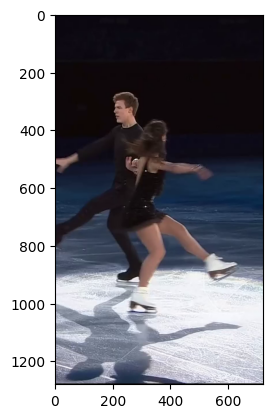

In [34]:
plt.imshow(frames[49])

In [35]:
# idx 49 – figure skating

In [39]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


2024-06-09 12:46:34.935948: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 12:46:36.375028: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [40]:
def get_single_image_embedding(my_image,processor, model, device):
    image = processor(
      text = None,
      images = my_image,
      return_tensors="pt"
      )["pixel_values"].to(device)
    embedding = model.get_image_features(image)
    # convert the embeddings to numpy array
    return embedding.cpu().detach().numpy()

embed = get_single_image_embedding(frames, processor, model, 'cpu')

In [42]:
embed.shape

(50, 512)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [77]:
query = "figure skating"

text_inp = processor(
    text = [query], images=None, return_tensors="pt"
)

text_emb = model.get_text_features(**text_inp).detach().numpy()

sim_scores = cosine_similarity(text_emb, embed)
indices = np.argsort(-sim_scores)

In [78]:
for idx, row in sample.iloc[indices[0]].iterrows():
    print(idx)
    print(row['link'])
    print(row['description'])
    print('-' * 45)

97307
https://cdn-st.rutubelist.ru/media/b1/ad/f38ec53a4fc79739c8acf7968041/fhd.mp4
#спорт #наспорте #растяжка #фитнес #мотивация #наспорте #тренировка #упражнения
---------------------------------------------
20554
https://cdn-st.rutubelist.ru/media/7f/31/a7791ed0473abf85c0599799d4dd/fhd.mp4
#спорт #наспорте #растяжка #фитнес #мотивация
---------------------------------------------
65770
https://cdn-st.rutubelist.ru/media/b4/20/839316f749088ba472d2e06b6342/fhd.mp4
#fashion #мода #красота #стиль #образ #модныйлук
---------------------------------------------
36925
https://cdn-st.rutubelist.ru/media/97/50/d81a7a994941a5183e563c65240f/fhd.mp4
Хочешь -11 см в животе А еще обрести подтянутое тело, убрать лишнюю жидкость, похудеть в боках и бедрах 10 марта стартует мой марафон по стройности!
---------------------------------------------
78025
https://cdn-st.rutubelist.ru/media/dc/39/9d1e35444b99948233289466c33a/fhd.mp4
#красивыедевушки #азиатки
---------------------------------------------
